# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA using Isomap as a dimensionality reduction technique

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = 'TP53' # TP53

Read the [docs](http://scikit-learn.org/stable/modules/manifold.html#complexity) on time complexity of the Isomap.

In [4]:
# Parameters for Dimensionality reduction
neighbors = 8

components = 64

# Parameter Sweep for Hyperparameters

param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'alpha': [10 ** x for x in range(-5, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [documentation](http://scikit-learn.org/stable/modules/manifold.html#isomap) regarding isomap as a dimensionality reduction technique.*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [5]:
url_to_path = {
    # X matrix
    'https://ndownloader.figshare.com/files/5514386':
        os.path.join('data', 'expression.tsv.bz2'),
    # Y Matrix
    'https://ndownloader.figshare.com/files/5514389':
        os.path.join('data', 'mutation-matrix.tsv.bz2'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

In [6]:
%%time
path = os.path.join('data', 'expression.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 2min 16s, sys: 1.1 s, total: 2min 17s
Wall time: 2min 17s


In [7]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 53s, sys: 796 ms, total: 1min 54s
Wall time: 1min 54s


In [8]:
y = Y[GENE]

In [9]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(5)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
Name: TP53, dtype: int64

In [10]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.655334
1    0.344666
Name: TP53, dtype: float64

## Set aside 10% of the data for testing

In [11]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,501 features, 6,935 training samples, 771 testing samples'

## Reduce the dimensionality via Isomap

In [12]:
transformer = Isomap(n_neighbors=neighbors, n_components=components, path_method='D', eigen_solver='arpack', n_jobs=1)

## Define pipeline and Cross validation model fitting

In [13]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
clf = SGDClassifier(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=1,scoring='roc_auc')
pipeline = make_pipeline(
    StandardScaler(),  # Feature scaling
    transformer, # Dimensionality reduction via Isomap
    clf_grid)

In [14]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_

CPU times: user 30min 15s, sys: 5.44 s, total: 30min 20s
Wall time: 30min 11s


In [15]:
clf_grid.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.5}

In [16]:
best_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.5,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=0, shuffle=True,
       verbose=0, warm_start=False)

## Visualize hyperparameters performance

In [17]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [18]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

/home/ktt/anaconda2/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,alpha,fold,l1_ratio,score
0,0.00001,0,0.0,0.749048
1,0.00001,1,0.0,0.785999


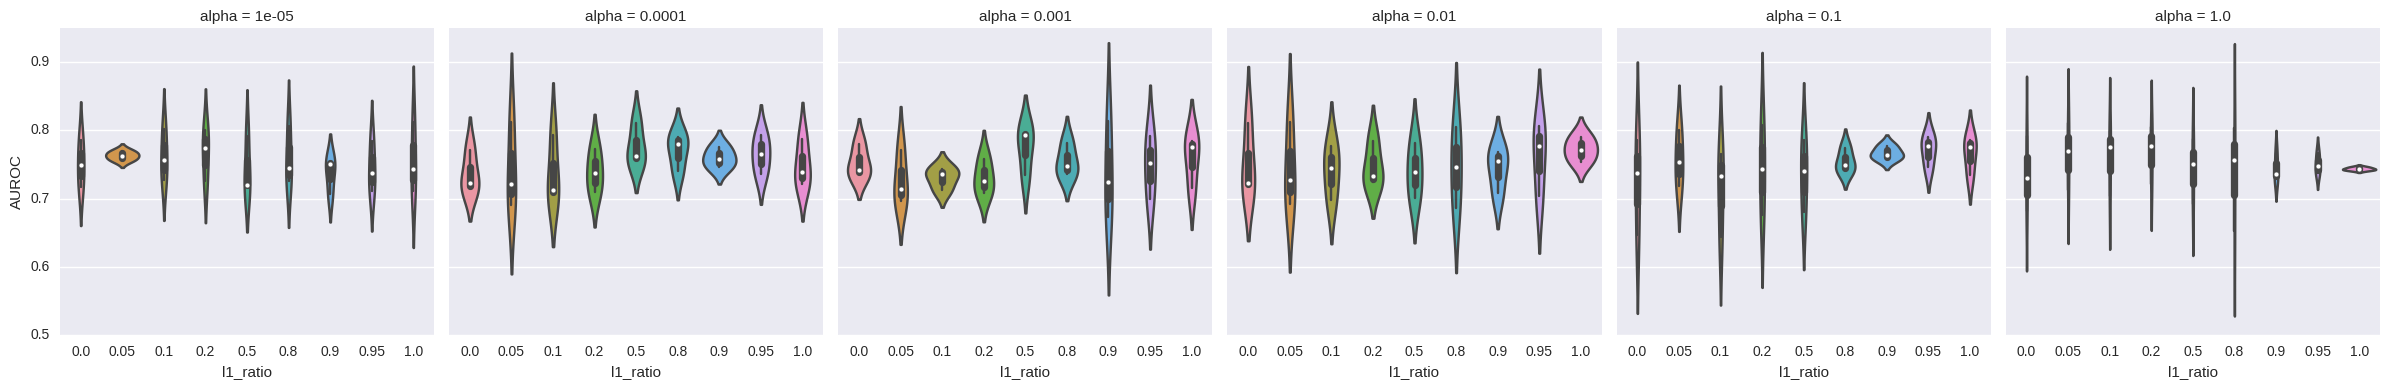

In [19]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='l1_ratio', y='score', col='alpha',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('AUROC');

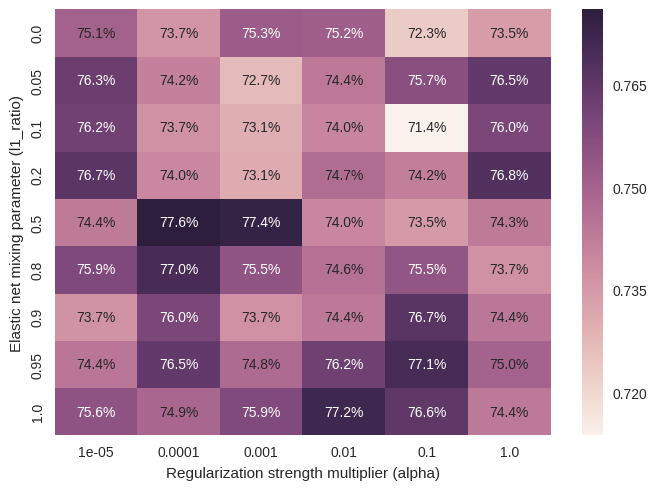

In [20]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='l1_ratio', columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [21]:
%%time
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

CPU times: user 32min 27s, sys: 2.35 s, total: 32min 29s
Wall time: 32min 32s


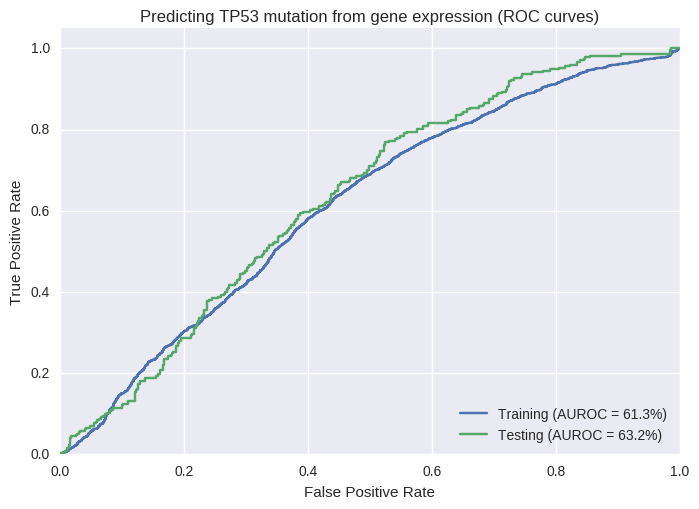

In [22]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## Investigate the predictions

In [23]:
%%time
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', pipeline.decision_function(X)),
    ('probability', pipeline.predict_proba(X)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

CPU times: user 1h 5min 7s, sys: 5.1 s, total: 1h 5min 12s
Wall time: 1h 5min 27s


In [24]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-DD-AACO-01,TCGA-DD-AACO-01,0,0,289138.053151,1.0,100.0%
TCGA-DD-AADS-01,TCGA-DD-AADS-01,0,0,284590.071984,1.0,100.0%
TCGA-ES-A2HS-01,TCGA-ES-A2HS-01,0,0,283605.575754,1.0,100.0%
TCGA-2Y-A9H1-01,TCGA-2Y-A9H1-01,1,0,279036.900340,1.0,100.0%
TCGA-WQ-A9G7-01,TCGA-WQ-A9G7-01,0,0,273606.140896,1.0,100.0%
TCGA-DD-AACD-01,TCGA-DD-AACD-01,0,0,270932.947488,1.0,100.0%
TCGA-E2-A574-01,TCGA-E2-A574-01,0,0,269928.421258,1.0,100.0%
TCGA-DD-A39V-01,TCGA-DD-A39V-01,0,0,267581.010188,1.0,100.0%
TCGA-DD-A116-01,TCGA-DD-A116-01,0,0,260553.478378,1.0,100.0%


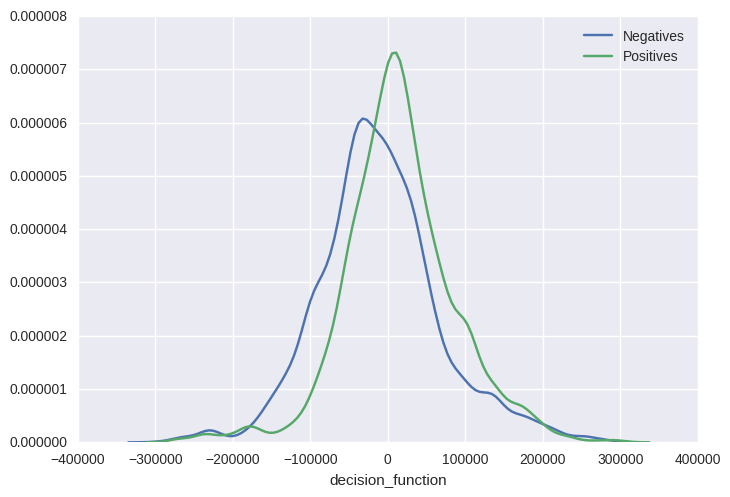

In [25]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

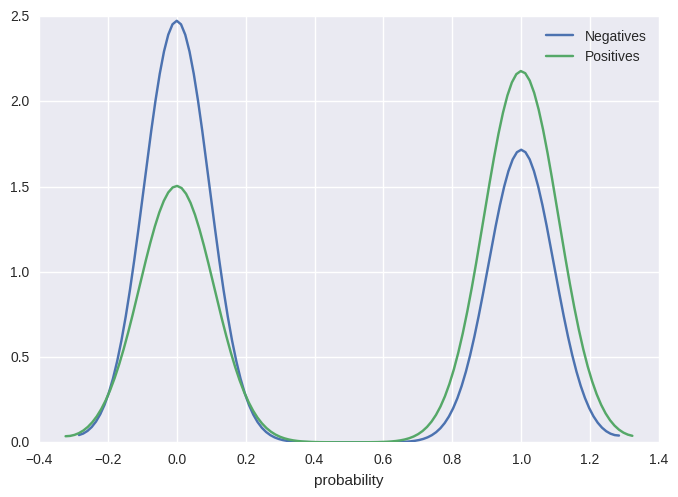

In [26]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')